In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append("../")
# TODO: hacky, shouldn't be necessary
os.chdir("/lustre_scratch/orlando-code/coralshift/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# import nctoolkit as nc
from pathlib import Path
import numpy as np
import haversine
import xarray as xa
# from haversine import haversine, Units, inverse_haversine

from coralshift.utils import directories

In [21]:
import numpy as np

# Create a 3D NumPy array with NaN values
arr = np.array([
    [[1, 2, 3], [4, 5, 2]],
    [[np.nan, 7, 8], [np.nan, 3, 11]]
])

# Check for NaN values along all dimensions (s, v, and t)
is_nan = np.isnan(arr).all(axis=(1))

In [24]:
# Add a new column (v+1) with binary values based on the NaN check
new_col = np.where(is_nan, 1, 0)
new_col

array([[0, 0, 0],
       [1, 0, 0]])

In [20]:

arr_with_new_col = np.concatenate((arr, new_col[:, np.newaxis, np.newaxis]), axis=1)

# Print the original array and the array with the new column
print("Original Array:")
print(arr)
print("\nArray with New Column:")
print(arr_with_new_col)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [164]:
### EXAMPLE: https://nctoolkit.readthedocs.io/en/latest/interpolation.html
ds1 = nc.open_thredds("https://psl.noaa.gov/thredds/dodsC/Datasets/COBE2/sst.mon.mean.nc")
ds1.subset(timestep = 0)
ds1.subset(lat = [0, 90])

ds2 = nc.open_thredds("https://psl.noaa.gov/thredds/dodsC/Datasets/COBE2/sst.mon.mean.nc")
ds2.subset(timestep = 0)
ds2.regrid(ds1, recycle=True)

In [29]:
class MyDataset:
    """Handle the variety of datasets required to test and train model"""
    # TODO: add in declaration of filepath root
    def __init__(self):
        self.datasets = {}
        self.files_location = Path()
        # fetching external functions

    def set_location(self, location="remote"):
        if location == "remote":
            # change directory to home. TODO: make less hacky
            os.chdir("/home/jovyan")
            self.files_location = Path("lustre_scratch/datasets/")
        elif location == "local":
            self.files_location = directories.get_volume_dir()
        else:
            raise ValueError

    def get_location(self):
        return self.files_location

    def add_dataset(self, name, data):
        self.datasets[name] = data

    def get_dataset(self, name):
        return self.datasets.get(name, None)

    def remove_dataset(self, name):
        if name in self.datasets:
            del self.datasets[name]

    def list_datasets(self):
        return list(self.datasets.keys())

In [30]:
ds_man = MyDataset()

# add datasets
ds_man.set_location("remote")

ds_man.add_dataset(
    "monthly_climate_1_12", xa.open_dataset(
        ds_man.get_location() / "global_ocean_reanalysis/monthly_means/coral_climate_1_12.nc")
)

coral_climate_feature_vars = list(
    set(ds_man.get_dataset("monthly_climate_1_12").data_vars) - {'spatial_ref', 'coral_algae_1-12_degree', 'output'})
ds_man.add_dataset(
    "monthly_climate_features", ds_man.get_dataset("monthly_climate_1_12")[coral_climate_feature_vars]
)

# ds_man.add_dataset(
#     "monthly_climate_1_12_y_np", np.array(ds_man.get_dataset("monthly_climate_1_12")["coral_algae_1-12_degree"].isel(time=-1)).reshape(-1, 1)
# )

ds_man.add_dataset(
    "monthly_climate_1_12_X_y_np", filter_out_nans(
        data.xa_ds_to_3d_numpy(ds_man.get_dataset("monthly_climate_1_12")), 
        np.array(ds_man.get_dataset("monthly_climate_1_12")["coral_algae_1-12_degree"].isel(time=-1)).reshape(-1, 1))
)

ds_man.add_dataset(
    "monthly_climate_1_12_X_np", ds_man.get_dataset("monthly_climate_1_12_X_y_np")[0]
)

ds_man.add_dataset(
    "monthly_climate_1_12_y_np", ds_man.get_dataset("monthly_climate_1_12_X_y_np")[1]
)

ds_man.add_dataset(
    "daily_climate_1_12", xa.open_dataset(
        Path(ds_man.get_location() / "global_ocean_reanalysis/daily_means/dailies_combined.nc"))
)

# same target as monthly
ds_man.add_dataset(
    "daily_climate_1_12_y_np", ds_man.get_dataset("monthly_climate_1_12_y_np")
)

ds_man.add_dataset(
    "bathymetry_A", rio.open_rasterio(
        rasterio.open(ds_man.get_location() / "bathymetry/GBR_30m/Great_Barrier_Reef_A_2020_30m_MSL_cog.tif"),
        ).rename("bathymetry_A").rename({"x": "longitude", "y": "latitude"})
)

NameError: name 'filter_out_nans' is not defined

In [274]:
def sample_spatial_batch(xa_ds: xa.Dataset, lat_lon_starts: tuple=(0,0), window_dims: tuple[int,int] = (6,6), 
    coord_range: tuple[float]=None, variables: list[str] = None) -> np.ndarray:
    """Sample a spatial batch from an xarray Dataset.

    Parameters
    ----------
        xa_ds (xa.Dataset): The input xarray Dataset.
        lat_lon_starts (tuple): Tuple specifying the starting latitude and longitude indices of the batch.
        window_dims (tuple[int, int]): Tuple specifying the dimensions (number of cells) of the spatial window.
        coord_range (tuple[float]): Tuple specifying the latitude and longitude range (in degrees) of the spatial 
            window. If provided, it overrides the window_dims parameter.
        variables (list[str]): List of variable names to include in the spatial batch. If None, includes all variables.

    Returns
    -------
        np.ndarray: The sampled spatial batch as a NumPy array.

    Notes
    -----
        - The function selects a subset of the input dataset based on the provided latitude, longitude indices, and window dimensions.
        - If a coord_range is provided, it is used to compute the latitude and longitude indices of the spatial window.
        - The function returns the selected subset as a NumPy array.

    Example
    -------
        # Sample a spatial batch from an xarray Dataset
        dataset = ...
        lat_lon_starts = (2, 3)
        window_dims = (6, 6)
        coord_range = (2.5, 3.5)
        variables = ['var1', 'var2', 'var3']
        spatial_batch = sample_spatial_batch(dataset, lat_lon_starts, window_dims, coord_range, variables)
    """
    # N.B. have to be careful when providing coordinate ranges for areas with negative coords. TODO: make universal
    lat_start, lon_start = lat_lon_starts[0], lat_lon_starts[1]
    if not coord_range:
        subset = xa_ds.isel({"latitude": slice(lat_start,window_dims[0]), 
                            "longitude": slice(lon_start,window_dims[1])})
    else:
        lat_cells, lon_cells = coord_range[0], coord_range[1]
        subset = xa_ds.sel({"latitude": slice(lat_start,lat_start+lat_cells), 
                            "longitude": slice(lon_start,lon_start+lon_cells)})

    lat_slice = subset["latitude"].values
    lon_slice = subset["longitude"].values
    time_slice = subset["time"].values

    return subset, {"latitude": lat_slice, "longitude": lon_slice, "time": time_slice}


In [289]:
# load bathymetry
bath_A = ds_man.get_dataset("bathymetry_A")
bath_A

<xarray.DataArray 'bathymetry_A' (band: 1, latitude: 23333, longitude: 16666)>
[388867778 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * longitude    (longitude) float64 142.0 142.0 142.0 ... 147.0 147.0 147.0
  * latitude     (latitude) float64 -10.0 -10.0 -10.0 ... -17.0 -17.0 -17.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

In [4]:
def degrees_to_distances(
    target_lat_res: float,
    target_lon_res: float = None,
    approx_lat: float = -18,
    approx_lon: float = 145,
) -> tuple[float]:
    """TODO: docstring"""
    start_coord = (approx_lat, approx_lon)
    lat_end_coord = (approx_lat + target_lat_res, approx_lon)
    # if both lat and lon resolutions specified
    if target_lon_res:
        lon_end_coord = (approx_lat, approx_lon + target_lon_res)
    else:
        lon_end_coord = (approx_lat, approx_lon + target_lat_res)

    return (haversine.haversine(start_coord, lat_end_coord, unit=haversine.Unit.METERS), 
        haversine.haversine(start_coord, lon_end_coord, unit=haversine.Unit.METERS))


def distance_to_degrees(
    distance_lat: float, distance_lon: float = None, approx_lat: float = -18, approx_lon: float = 145
) -> tuple[float, float, float]:
    # TODO: enable specification of distance in different orthogonal directions
    """Converts a distance in meters to the corresponding distance in degrees, given an approximate location on Earth.

    Parameters
    ----------
    distance (float): The distance in meters.
    approx_lat (float, optional): The approximate latitude of the location in degrees. Defaults to -18.0.
    approx_lon (float, optional): The approximate longitude of the location in degrees. Defaults to 145.0.

    Returns
    -------
    float: The corresponding distance in degrees.
    """
    # if distance_lon not provided, assume the same as distance_lat
    if not distance_lon:
        distance_lon = distance_lat

    degrees_lat = haversine.inverse_haversine(
        (approx_lat, approx_lon),
        distance_lat,
        haversine.Direction.SOUTH,
        unit=haversine.Unit.METERS)
    
    degrees_lon = haversine.inverse_haversine(
        (approx_lat, approx_lon),
        distance_lon,
        haversine.Direction.WEST,
        unit=haversine.Unit.METERS)

    # calculate the coordinates 'distance' meters to the southwest (chosen to give measure of both lat and lon)
    av_distance = (distance_lat+distance_lon)/2
    (lat_deg, lon_deg) = haversine.inverse_haversine(
        (approx_lat, approx_lon),
        av_distance,
        haversine.Direction.SOUTHWEST,
        unit=haversine.Unit.METERS,
    )
    delta_lat, delta_lon = abs(lat_deg - approx_lat), abs(lon_deg - approx_lon)
    # return hypotenuse (encapsulates difference in both lat and lon)
    return (np.subtract((approx_lat, approx_lon), degrees_lat)[0], np.subtract((approx_lat, approx_lon), degrees_lon)[1],
        np.hypot(delta_lat, delta_lon))

In [11]:
# degrees_to_distances(0.00898315)
distance_to_degrees(4000)

(0.03597281454898038, 0.03782405507308795, 0.03691157541051416)

(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': ' DEM upsampled to 0.00898315 degrees'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fa6ac4fadd0>)

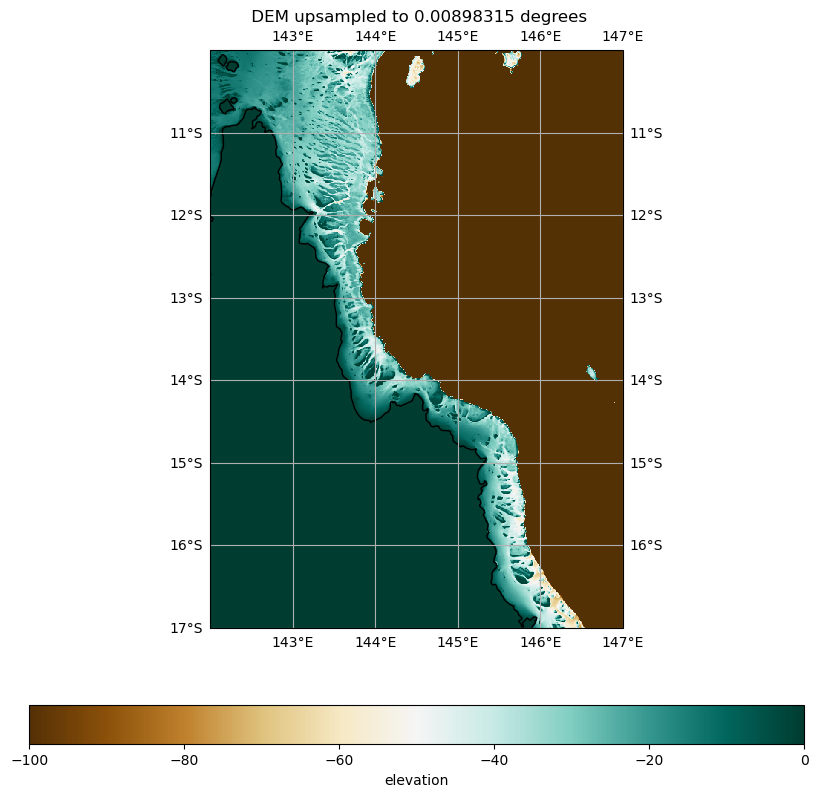

In [383]:
# 1 km. Struggles displaying/processing 100m, but have yet to try saving to this/inferring
_,_,av_degrees = distance_to_degrees(1000)
coarsened_bath_A = data.upsample_xarray_to_target(bath_A, av_degrees)
# im = coarsened_bath_A.plot(ax=ax)

spatial_plots.plot_DEM(coarsened_bath_A, f" DEM upsampled to {target_resolution} degrees", vmin=-100, vmax=0)
# spatial_plots.format_spatial_plot(im, fig, ax, f"Upsampled to {target_resolution} degrees")

In [ ]:
# carving off small slice

# 1km upscale ground truth, bathymetry

# regrid ground truth, bathymetry, climate 

In [276]:
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
c

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 2.],
       [3., 4.]], dtype=float32)>

In [279]:
c.value()

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'value'

In [126]:
ds_man.add_dataset(
    "bathymetry_A", rio.open_rasterio(
        rasterio.open(ds_man.get_location() / "bathymetry/GBR_30m/test_A.nc"),
        ).rename("bathymetry_A")
)

In [127]:
bath_A = ds_man.get_dataset("bathymetry_A")
bath_A = bath_A.rename({"x": "longitude", "y": "latitude"})
bath_A

<xarray.DataArray 'bathymetry_A' (band: 1, latitude: 23333, longitude: 16666)>
[388867778 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * longitude    (longitude) float64 142.0 142.0 142.0 ... 147.0 147.0 147.0
  * latitude     (latitude) float64 -10.0 -10.0 -10.0 ... -17.0 -17.0 -17.0
    spatial_ref  int64 0
Attributes:
    latitude#_FillValue:     nan
    longitude#_FillValue:    nan
    NETCDF_DIM_band_DEF:     [ 1. 10.]
    NETCDF_DIM_band_VALUES:  1
    NETCDF_DIM_EXTRA:        {band}
    add_offset:              0.0
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    _FillValue:              -9999.0

In [176]:
ds_climate_monthly_1_12 = ds_man.get_dataset("monthly_climate_1_12")
ds_climate_monthly_1_12_small = ds_climate_monthly_1_12.sel(latitude=slice(-10,-10.1), longitude=slice(142,142.1))

In [156]:
data_var_list = list(ds_climate_monthly_1_12_small.data_vars)
variables = out + data_var_list

In [177]:
ds_climate_monthly_1_12_small = ds_climate_monthly_1_12_small[variables]
ds_climate_monthly_1_12_small

<xarray.Dataset>
Dimensions:                  (time: 336, latitude: 2, longitude: 1)
Coordinates:
  * time                     (time) datetime64[ns] 1993-01-16T12:00:00 ... 20...
  * latitude                 (latitude) float64 -10.0 -10.09
  * longitude                (longitude) float64 142.1
    depth                    float32 ...
Data variables: (12/13)
    spatial_ref              (latitude, longitude, time) int64 0 0 0 0 ... 0 0 0
    coral_algae_1-12_degree  (latitude, longitude, time) float64 1.0 1.0 ... 1.0
    mlotst                   (latitude, longitude, time) float32 7.02 ... 7.037
    siconc                   (latitude, longitude, time) float32 nan nan ... nan
    thetao                   (latitude, longitude, time) float32 28.96 ... 30.66
    usi                      (latitude, longitude, time) float32 0.0 0.0 ... nan
    ...                       ...
    bottomT                  (latitude, longitude, time) float32 28.93 ... 30.59
    vsi                      (latitude, longitude, time) float32 0.0 0.0 ... nan
    vo                       (latitude, longitude, time) float32 0.03908 ... ...
    uo                       (latitude, longitude, time) float32 -0.01289 ......
    so                       (latitude, longitude, time) float32 33.84 ... 35.19
    zos                      (latitude, longitude, time) float32 0.6504 ... 0...

In [197]:
climate_path = str(ds_man.get_location() / "global_ocean_reanalysis/daily_means/dailies_combined.nc")

In [246]:
climate_xa = xa.open_dataset(climate_path)
climate_xa

<xarray.Dataset>
Dimensions:    (latitude: 85, time: 9863, longitude: 61, depth: 17)
Coordinates:
  * latitude   (latitude) float32 -17.0 -16.92 -16.83 ... -10.17 -10.08 -10.0
  * time       (time) datetime64[ns] 1993-12-31T12:00:00 ... 2020-12-31T12:00:00
  * longitude  (longitude) float32 142.0 142.1 142.2 142.2 ... 146.8 146.9 147.0
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 29.44 34.43 40.34
Data variables:
    bottomT    (time, latitude, longitude) float32 ...
    mlotst     (time, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
Attributes: (12/25)
    title:                              daily mean fields from Global Ocean P...
    easting:                            longitude
    northing:                           latitude
    history:                            2022/05/25 21:54:07 MERCATOR OCEAN Ne...
    source:                             MERCATOR GLORYS12V1
    institution:                        MERCATOR OCEAN
    ...                                 ...
    FROM_ORIGINAL_FILE__longitude_max:  179.91667
    FROM_ORIGINAL_FILE__latitude_min:   -80.0
    FROM_ORIGINAL_FILE__latitude_max:   90.0
    z_min:                              0.494025
    z_max:                              5727.917
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention

In [253]:
restrict_xa = climate_xa.isel(time=slice(0,10), latitude=slice(0,2), longitude=slice(0,2), depth=0)
restrict_xa.to_netcdf("lustre_scratch/datasets/global_ocean_reanalysis/daily_means/restrict_xa.nc")
restrict_nc = nc.open_data("lustre_scratch/datasets/global_ocean_reanalysis/daily_means/restrict_xa.nc")

The variable(s) bottomT,mlotst,so,thetao,uo,vo,zos have integer data type. Consider setting data type to float 'F64' or 'F32' using set_precision.


In [229]:
ds = nc.open_data(climate_path)

The variable(s) bottomT,mlotst,so,thetao,uo,vo,zos have integer data type. Consider setting data type to float 'F64' or 'F32' using set_precision.


In [218]:
ds_static.times

AttributeError: 'NoneType' object has no attribute 'times'

In [261]:
restrict_nc.regrid(restrict_nc)

In [258]:
out

In [154]:
ds_climate_monthly_1_12_small.dims

Frozen({'time': 336, 'latitude': 2, 'longitude': 1})

In [155]:
ds_bath.dims

AttributeError: 'DataSet' object has no attribute 'dims'

In [158]:
ds_climate = nc.from_xarray(ds_climate_monthly_1_12_small)
ds_bath = nc.from_xarray(bath_A)

In [175]:
ds_climate.months

[1]

In [163]:
ds_bath.variables

['bathymetry_A']

In [159]:
ds_climate.regrid(ds_climate)

ValueError: Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable spatial_ref!Warning (cdf_set_var): Inconsistent variable definition for spatial_ref!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable coral_algae_1-12_degree!Warning (cdf_set_var): Inconsistent variable definition for coral_algae_1-12_degree!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable mlotst!Warning (cdf_set_var): Inconsistent variable definition for mlotst!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable siconc!Warning (cdf_set_var): Inconsistent variable definition for siconc!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable thetao!Warning (cdf_set_var): Inconsistent variable definition for thetao!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable usi!Warning (cdf_set_var): Inconsistent variable definition for usi!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable sithick!Warning (cdf_set_var): Inconsistent variable definition for sithick!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable bottomT!Warning (cdf_set_var): Inconsistent variable definition for bottomT!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable vsi!Warning (cdf_set_var): Inconsistent variable definition for vsi!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable vo!Warning (cdf_set_var): Inconsistent variable definition for vo!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable uo!Warning (cdf_set_var): Inconsistent variable definition for uo!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable so!Warning (cdf_set_var): Inconsistent variable definition for so!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable zos!Warning (cdf_set_var): Inconsistent variable definition for zos!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable spatial_ref!Warning (cdf_set_var): Inconsistent variable definition for spatial_ref!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable coral_algae_1-12_degree!Warning (cdf_set_var): Inconsistent variable definition for coral_algae_1-12_degree!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable mlotst!Warning (cdf_set_var): Inconsistent variable definition for mlotst!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable siconc!Warning (cdf_set_var): Inconsistent variable definition for siconc!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable thetao!Warning (cdf_set_var): Inconsistent variable definition for thetao!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable usi!Warning (cdf_set_var): Inconsistent variable definition for usi!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable sithick!Warning (cdf_set_var): Inconsistent variable definition for sithick!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable bottomT!Warning (cdf_set_var): Inconsistent variable definition for bottomT!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable vsi!Warning (cdf_set_var): Inconsistent variable definition for vsi!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable vo!Warning (cdf_set_var): Inconsistent variable definition for vo!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable uo!Warning (cdf_set_var): Inconsistent variable definition for uo!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable so!Warning (cdf_set_var): Inconsistent variable definition for so!Warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable zos!Warning (cdf_set_var): Inconsistent variable definition for zos!cdo    genbil (Abort): Unsupported projection coordinates (Variable: coral_algae_1-12_degree)!

In [ ]:
import cf

In [ ]:
cf.example_fields(2)

[<CF Field: air_potential_temperature(time(36), latitude(5), longitude(8)) K>]

In [ ]:
bath_A.to_netcdf(ds_man.get_location() / "bathymetry/GBR_30m/test_A.nc")

In [ ]:
dst, 

In [ ]:
dst = cf.read(ds_man.get_location() / "bathymetry/GBR_30m/test_A.nc")

In [ ]:
dst.select_by_ncvar("bathymetry_A")

[<CF Field: ncvar%bathymetry_A(ncdim%band(1), ncdim%latitude(23333), ncdim%longitude(16666))>]

In [ ]:
srces = cf.read(ds_man.get_location() / "global_ocean_reanalysis/monthly_means/coral_climate_1_12.nc")

In [ ]:
srces[5]

<CF Field: sea_water_salinity(ncdim%latitude(187), ncdim%longitude(137), time(336)) 1e-3>

In [ ]:
lat = cf.DimensionCoordinate(data = cf.Data(np.arange(-17, -10, 0.01), "lats"))
lon = cf.DimensionCoordinate(data = cf.Data(np.arange(142, 147, 0.01), "lons"))

In [ ]:
g = srces[5].regrids(dst, method='linear')


ValueError: When 'dst' is a sequence it must be of latitude and longitude coordinate constructs. Got: [<CF Field: ncvar%bathymetry_A(ncdim%band(1), ncdim%latitude(23333), ncdim%longitude(16666))>]

In [ ]:
bath_A = ds_man.get_dataset("bathymetry_A")
bath_A = bath_A.rename({"x": "longitude", "y": "latitude"})
bath_A

<xarray.DataArray 'bathymetry_A' (band: 1, latitude: 23333, longitude: 16666)>
[388867778 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * longitude    (longitude) float64 142.0 142.0 142.0 ... 147.0 147.0 147.0
  * latitude     (latitude) float64 -10.0 -10.0 -10.0 ... -17.0 -17.0 -17.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
bath_A.values[:, None, :].shape

(1, 1, 23333, 16666)

In [ ]:
ds_climate_monthly_1_12 = ds_man.get_dataset("monthly_climate_1_12")
ds_climate_monthly_1_12_A = ds_climate_monthly_1_12.sel(latitude=slice(-10,-17), longitude=slice(142,147))

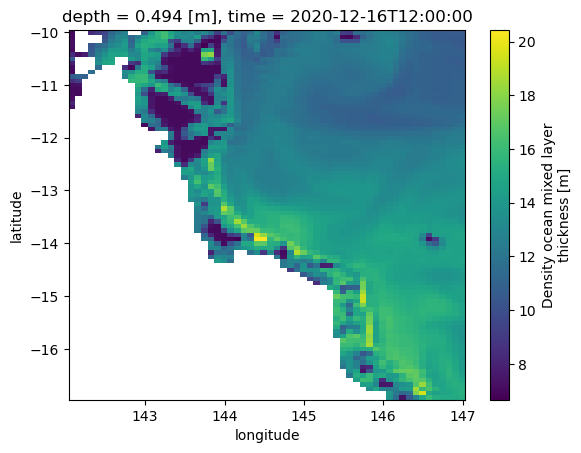

In [ ]:
ds_climate_monthly_1_12_A["mlotst"].isel(time=-1).plot()

In [ ]:
### Testing interp_like
climate_m_small = ds_climate_monthly_1_12_A.sel(latitude=slice(-10,-10.2), longitude=slice(142,142.2))
bath_A_small = bath_A.sel(latitude=slice(-10,-10.2), longitude=slice(145,145.2))

In [ ]:
check = climate_m_small.interp_like(bath_A_small)

In [ ]:
check

<xarray.Dataset>
Dimensions:                  (latitude: 666, longitude: 666, time: 336)
Coordinates:
    depth                    float32 0.494
  * time                     (time) datetime64[ns] 1993-01-16T12:00:00 ... 20...
  * latitude                 (latitude) float64 -10.0 -10.0 ... -10.2 -10.2
  * longitude                (longitude) float64 145.0 145.0 ... 145.2 145.2
Data variables: (12/13)
    spatial_ref              (latitude, longitude, time) float64 nan nan ... nan
    coral_algae_1-12_degree  (latitude, longitude, time) float64 nan nan ... nan
    mlotst                   (latitude, longitude, time) float64 nan nan ... nan
    siconc                   (latitude, longitude, time) float64 nan nan ... nan
    thetao                   (latitude, longitude, time) float64 nan nan ... nan
    usi                      (latitude, longitude, time) float64 nan nan ... nan
    ...                       ...
    bottomT                  (latitude, longitude, time) float64 nan nan ... nan
    vsi                      (latitude, longitude, time) float64 nan nan ... nan
    vo                       (latitude, longitude, time) float64 nan nan ... nan
    uo                       (latitude, longitude, time) float64 nan nan ... nan
    so                       (latitude, longitude, time) float64 nan nan ... nan
    zos                      (latitude, longitude, time) float64 nan nan ... nan

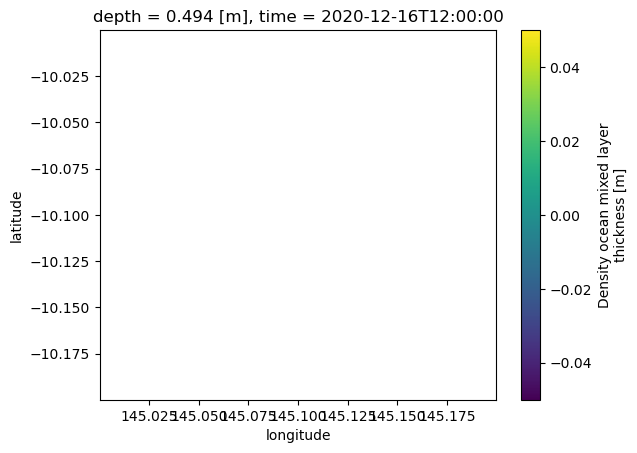

In [ ]:
check["mlotst"].isel(time=-1).plot()

In [ ]:
ds_climate_monthly_1_12_A, bath_A = xa.broadcast(ds_climate_monthly_1_12_A, bath_A)

In [ ]:
# Assuming you have the high-resolution and low-resolution xarray datasets named 'bath_A' and 'ds_climate_monthly_1_12_A'

# Extract the latitude and longitude coordinates from the high-resolution dataset
lat_hr = bath_A['latitude'].values
lon_hr = bath_A['longitude'].values

# Extract the latitude and longitude coordinates from the low-resolution dataset
lat_lr = ds_climate_monthly_1_12_A['latitude'].values
lon_lr = ds_climate_monthly_1_12_A['longitude'].values

# Get the values of the low-resolution array
ds_climate_monthly_1_12_A_values = ds_climate_monthly_1_12_A['bottomT'].values

# Create a new high-resolution array with the same values for each time step
bath_A_values = np.broadcast_to(bath_A.values[:, None, :], ds_climate_monthly_1_12_A_values.shape)


# # Create a 2D meshgrid for the high-resolution coordinates
# lon_hr_mesh, lat_hr_mesh = np.meshgrid(lon_hr, lat_hr)

# # Create a 2D meshgrid for the low-resolution coordinates
# lon_lr_mesh, lat_lr_mesh = np.meshgrid(lon_lr, lat_lr)

# # Get the values of the low-resolution array
# low_res_values = ds_climate_monthly_1_12_A['bottomT'].values

ValueError: input operand has more dimensions than allowed by the axis remapping

In [ ]:
low_res_values.shape

(84, 60, 336)

In [ ]:
# Interpolate the low-resolution values onto the high-resolution grid
interp_func = interp2d(lon_lr_mesh, lat_lr_mesh, low_res_values, kind='linear')
high_res_values = interp_func(lon_hr, lat_hr)

# # Create a new xarray dataset with the interpolated values
# combined_ds = xa.Dataset(
#     {
#         'data_variable': (('lat', 'lon'), high_res_values),
#     },
#     coords={'lat': lat_hr, 'lon': lon_hr}
# )

/tmp/ipykernel_8480/1913092295.py:2: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  interp_func = interp2d(lon_lr_mesh, lat_lr_mesh, low_res_values, kind='linear')


ValueError: Invalid length for input z for non rectangular grid

In [ ]:
# will need to try with GEE or do in smaller chunks
# cut out nan vars before this. Huge memory consumption and not even the daily...
climate_m_small = ds_climate_monthly_1_12_A.sel(latitude=slice(-10,-10.2), longitude=slice(142,142.2))
bath_A_small = bath_A.sel(latitude=slice(-10,-10.2), longitude=slice(142,142.2))
climate_resolution_monthly_reindexed = climate_m_small.reindex_like(bath_A_small, method='nearest')
# takes ~ 40s

In [ ]:
ds_climate_daily_1_12 = ds_man.get_dataset("daily_climate_1_12")
ds_climate_daily_1_12_A = ds_climate_daily_1_12.sel(latitude=slice(-10,-17), longitude=slice(142,147))

In [ ]:
# completely destroys kernel memory usage
climate_d_small = ds_climate_daily_1_12_A.sel(latitude=slice(-10,-10.2), longitude=slice(142,142.2))
climate_resolution_daily_reindexed = climate_d_small.reindex_like(bath_A_small, method='nearest')

In [ ]:
test = climate_resolution_monthly_reindexed.merge(bath_A_small)
# climate_resolution_daily_reindexed

In [ ]:
climate_resolution_reindexed

In [ ]:
climate_resolution_reindexed = 0

In [ ]:
climate_resolution_broadcasted = climate_resolution_reindexed.broadcast_like(test)
climate_resolution_broadcasted